This code is one of the tasks during the ML-training 
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev
The code on building and training the model was created by [Hanna Kaleichyk](https://www.linkedin.com/in/hanna-kaleichyk-108aba245)

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 47, 64, ..., 61, 64, 48],
       [83, 53,  5, ...,  1, 46, 64],
       [83, 49, 63, ..., 45,  1, 49],
       ...,
       [83, 54,  5, ..., 63,  1, 50],
       [83, 54,  1, ..., 49, 50, 47],
       [83, 72,  1, ..., 59, 56, 59]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [7]:
class charRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(charRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Embed the input
        x_emb = self.embedding(input)
        x_emb = x_emb.to(device)
        # Pass through the LSTM
        output, hidden = self.lstm(x_emb, hidden)
        # Pass through the fully connected layer
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        # Initialize the hidden state for LSTM (n_layers, batch_size, hidden_size)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)  # Hidden state
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device) # Cell state
        return (h_0, c_0)

In [8]:
def rnn_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size = batch_ix.shape[0]
    hid_state = model.init_hidden(batch_size)  # Initialize hidden state

    # Pass the entire sequence to the model (batch_first=True already handles batching)
    output, hid_state = model(batch_ix, hid_state)  # Process the entire batch at once

    return output

In [11]:
from IPython.display import clear_output
from random import sample
import time

n_epochs = 10000
print_every = 100
hidden_size = 256
n_layers = 1
lr = 0.005

loss_func = nn.CrossEntropyLoss()
char_rnn = charRNN(batch_size, hidden_size, len(token_to_idx), n_layers).to(device)
opt = torch.optim.Adam(char_rnn.parameters(), lr=lr)
history = []

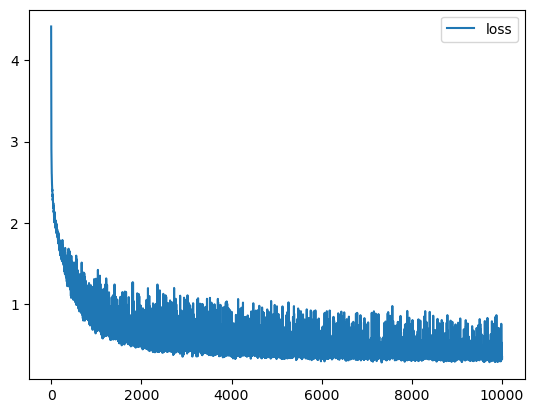

Training on cuda took 4446.83 seconds.


In [12]:
start_time=time.time()
for i in range(n_epochs):
    opt.zero_grad()
    batch_ix = next(generate_chunk())  # Shape: [batch_size, seq_length]
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    all_logits = rnn_loop(char_rnn, batch_ix)
    # compute loss
    actual_next_tokens = batch_ix[:, 1:]

    pred_logits = all_logits[:, :-1, :]
    pred_logits_flattened = pred_logits.reshape(-1, pred_logits.shape[-1])
    actual_next_tokens_flattened = actual_next_tokens.reshape(-1)
    loss = loss_func(pred_logits_flattened, actual_next_tokens_flattened)
    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.item())
    if (i + 1) % print_every == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()
end_time = time.time()
total_time = end_time - start_time 
print(f"Training on {device} took {total_time:.2f} seconds.")
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

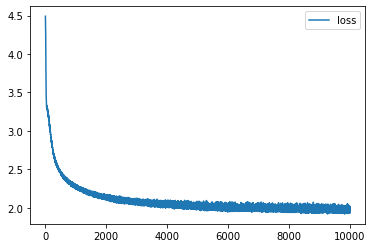

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [13]:
import torch
import numpy as np

def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    """
    Generate text using the trained charRNN model given a seed phrase.
    :param seed_phrase: Prefix characters for the RNN to continue from.
    :param max_length: Maximum length of the generated text (including seed_phrase).
    :param temperature: Controls the randomness of predictions. Higher values (e.g., 1.0) give more random predictions.
                        Lower values (e.g., 0.5) make predictions more deterministic.
    :param device: Device to run the model on ('cuda' or 'cpu').
    :return: Generated text.
    """
    # Convert the seed_phrase to a sequence of indices
    if seed_phrase is None:
        seed_phrase = '<sos>' 
    
    # Map characters to indices
    idxs = [token_to_idx[c] for c in seed_phrase]
    input_sequence = torch.tensor(idxs, dtype=torch.int64).unsqueeze(0).to(device)  # Shape: [1, seq_len]
    
    # Initialize hidden state for LSTM
    hidden = char_rnn.init_hidden(1)
    
    # Store the generated text
    generated_text = seed_phrase
    
    # Generate text until max_length
    for _ in range(max_length - len(seed_phrase)):
        output, hidden = char_rnn(input_sequence, hidden)
        last_output = output[:, -1, :]  # Shape: [1, vocab_size]
        
        # Apply temperature scaling
        last_output = last_output / temperature
        
        probabilities = torch.nn.functional.softmax(last_output, dim=-1).cpu().detach().numpy().flatten()
        
        next_token_idx = np.random.choice(len(probabilities), p=probabilities)
        
        # Convert index back to character
        next_char = idx_to_token.get(next_token_idx)
        
        # Append the character to the generated text
        generated_text += next_char
        
        # Update input_sequence for the next timestep (use the last generated token)
        input_sequence = torch.tensor([[next_token_idx]], dtype=torch.int64).to(device)
    
    return generated_text


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [14]:
len(generate_sample(char_rnn, ' мой дядя самых честных правил ', max_length=500, temperature=0.5))

500

In [18]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правил
и зловенным вновь охотно
его где же, милый, вздыха
двери надежды ей селить презренье
в сем сердце бедня, весна!



xxxix

приплючи нет, эпимиться
или на двор они мне таня:
что звал евгений на дворе
и тай мой усы, ко мненье,
могу прокоительному старины,
и снег, волшебный взор
и что почте поздравлять,
чтоб остальное вражом он странных,
так на мароне, на двор
ему на соленный, беспечны вновь,
дыханьем ночи благосклонной
безмолвный входит на луга;
но подобно и мира!






### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [19]:
 generated_phrases = [
     generate_sample(
         char_rnn,
         ' мой дядя самых честных правил',
         max_length=500,
         temperature=0.5
     )
     for _ in range(10)
 ]

In [20]:
len(generated_phrases[1])

500

In [21]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!

In [22]:
torch.save(char_rnn.state_dict(), './char_rnn')